# Toy model


## Method 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [2]:
cov = [[5, 0], [0, 5]]
mean = [35, 30]
nEvents = 100

injections = np.random.multivariate_normal(mean, cov, nEvents)
inj_sorted = np.sort(injections, axis=1)

In [3]:
m2, m1 = inj_sorted[:, 0], inj_sorted[:, 1]


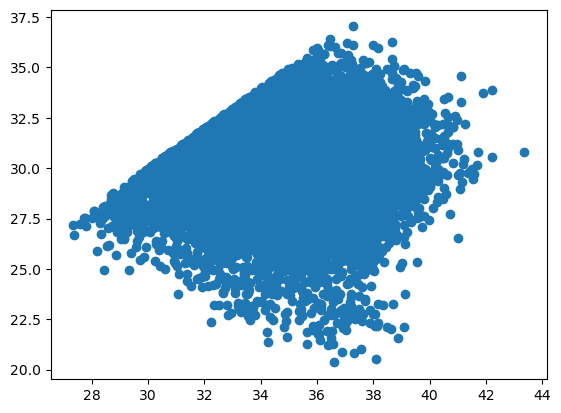

In [4]:
m1s = []
m2s = []
for i in range(nEvents):
    mean = [m1[i], m2[i]]
    cov = [[1, 0], [0, 1]]  
    samples = np.random.multivariate_normal(mean, cov, 100)
    inj_sorted = np.sort(samples, axis=1)
    m1s.append(inj_sorted[:, 1])
    m2s.append(inj_sorted[:, 0])



plt.scatter(m1s, m2s)

In [5]:
m1s = np.concatenate(m1s)
m2s = np.concatenate(m2s)

samples = np.array([m1s, m2s])

In [6]:
m1s.shape, samples.shape

((10000,), (2, 10000))

In [7]:
samples[0].shape

(10000,)

In [8]:
# cov = [[1, 0], [0, 1]]
# nsamp = 1000

# samples = np.random.multivariate_normal([35,35], cov, nsamp)

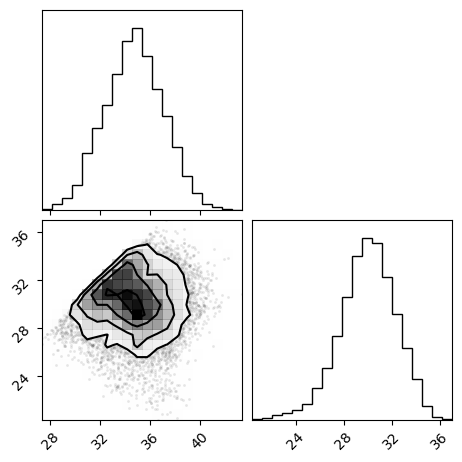

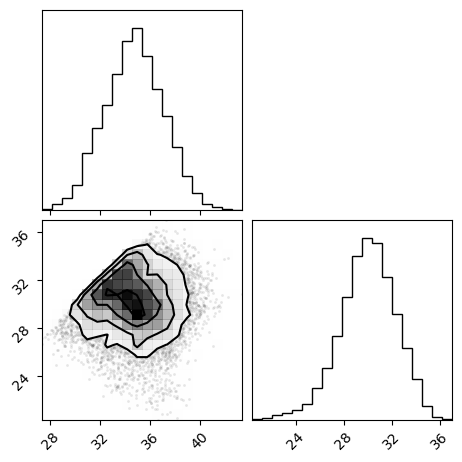

In [9]:
import corner 

corner.corner(samples.T)

In [10]:
mass = np.linspace(1, 100, 1000)
mass_ratio = np.linspace(1, 100, 1000)

def pm1_peak(m1,mu,sigma):
    pm1 =  jnp.exp(-(mass - mu)**2 / (2 * sigma ** 2))
    pm1 = pm1/jnp.trapezoid(pm1,mass)
    return jnp.interp(m1,mass,pm1)

def joint_pdf(m1, q, mu0, sig0, mu1, sig1):
    pm1 = pm1_peak(m1, mu0, sig0)
    pq = pm1_peak(q, mu1, sig1)
    
    return pm1 * pq

def log_joint_pdf(m1, q, mu0, sig0, mu1, sig1):
    pm1 = jnp.log(pm1_peak(m1, mu0, sig0))
    pq = jnp.log(pm1_peak(q, mu1, sig1))
    
    return pm1 + pq

In [11]:
mu0 = 35
mu1 = 30

sig0 = 1
sig1 = 1

logp = log_joint_pdf(samples[0], samples[1], mu0, sig0, mu1, sig1)

In [12]:
samples[0]

array([36.09221881, 36.43603804, 36.51270012, ..., 38.02984069,
       38.62268376, 38.44559507], shape=(10000,))

In [13]:
samples.shape

(2, 10000)

In [14]:
from jax.scipy.special import logsumexp

jnp.sum(-jnp.log(10000) + jnp.nan_to_num(logsumexp(logp,axis=-1)))

Array(-3.7631779, dtype=float32)

## Method 2

In [15]:
import jax

def m1_q_samples(n_samples, mu0=35, mu1=30, sig0=1, sig1=1, key=None):
    """Optimized version that properly handles dynamic n_samples."""
    
    # Create grid - these operations are static
    m1_grid, q_grid = jnp.meshgrid(mass, mass_ratio, indexing='ij')

    def compute_pdf(m1, q):
        pm1 = pm1_peak(m1, mu0, sig0)
        pq = pm1_peak(q, mu1, sig1)
        
        jax.debug.print("pm1: {}", pm1)
        jax.debug.print("pq: {}", pq)
        
        return pm1*pq
    
    joint_pdf = compute_pdf(m1_grid.ravel(), q_grid.ravel()).reshape(1000, 1000)
    joint_pdf /= jnp.sum(joint_pdf)  # Normalize

    # Compute CDF
    cdf = jnp.cumsum(joint_pdf.ravel())
    cdf /= cdf[-1]

    # Sampling - this part handles dynamic n_samples
    key = jax.random.PRNGKey(42) if key is None else key
    u = jax.random.uniform(key, shape=(n_samples,))
    indices = jnp.searchsorted(cdf, u)
    idx_m1, idx_q = jnp.unravel_index(indices, (1000, 1000))

    return mass[idx_m1], mass_ratio[idx_q]

In [16]:
def metro_2dmc(nsamp=10000,
             mu0=35, sig0=1, mu1=30, sig1=1,
             m_min=5.0, m_max=100.0,
             q_min=5.0, q_max=100.0,
             proposal_std_m=3.0, proposal_std_q=3.0):
    """
    Simple Metropolis-Hastings sampling of (m1, q) within [m_min, m_max] × [q_min, q_max].
    - compute_pdf(m1, q) should return non-negative density (unnormalized).
    """
    samples = np.zeros((nsamp, 2))
    p_vals = np.zeros(nsamp)

    # Example compute_pdf using some user-defined pm1_peak and fq functions.
    # These must be defined elsewhere and accept numpy floats (or arrays).
    def compute_pdf(m1, q):
        # Check bounds; return zero density outside
        if (m1 < m_min) or (m1 > m_max) or (q < q_min) or (q > q_max): 
            return 0.0
        # User’s functions; ensure they accept/return numpy floats
        pm1 = pm1_peak(m1, mu0, sig0)    # e.g. Gaussian in m1
        pq = pm1_peak(q, mu1, sig1)               # e.g. power-law in q
        # If these return arrays, ensure you index appropriately.
        # Here assume they return scalar floats when inputs are floats.
        return pm1 * pq

    # Initialize first sample somewhere inside the domain.
    # Could choose (mu, midpoint of q-range) or draw random uniform:
    samples[0, 0] = np.clip(mu0, m_min, m_max)  # or np.random.uniform(m_min, m_max)
    samples[0, 1] = np.clip(mu1, q_min, q_max)
    # samples[0, 1] = np.clip((q_min + q_max) / 2, q_min, q_max)
    # samples[0, 2] = np.clip((z_min + z_max) / 2, z_min, z_max)
    p_vals[0] = compute_pdf(samples[0,0], samples[0,1])

    for i in range(1, nsamp):
        current_m, current_q = samples[i-1]
        # Propose new point via Gaussian steps:
        prop_m = current_m + np.random.normal(scale=proposal_std_m)
        prop_q = current_q + np.random.normal(scale=proposal_std_q)
        # Boundary check: if out of allowed range, reject immediately
        if (prop_m < m_min) or (prop_m > m_max) or (prop_q < q_min) or (prop_q > q_max):
            # reject: keep previous
            samples[i] = samples[i-1]
            p_vals[i] = p_vals[i-1]
            continue

        # Otherwise compute density at proposal
        p_prop = compute_pdf(prop_m, prop_q)
        p_curr = p_vals[i-1]

        # If current density is zero (should not happen if initialization in support), you might treat carefully:
        if p_curr <= 0:
            # To avoid division by zero, you could automatically accept if p_prop>0,
            # or simply set accept=False; depends on context. Here, if current has zero density but proposal>0,
            # you might accept to move into support:
            accept = (p_prop > 0)
        else:
            # Standard Metropolis acceptance:
            if p_prop >= p_curr:
                accept = True
            else:
                accept = np.random.rand() < (p_prop / p_curr)

        if accept:
            samples[i, 0] = prop_m
            samples[i, 1] = prop_q
            p_vals[i] = p_prop
        else:
            samples[i] = samples[i-1]
            p_vals[i] = p_curr

    return samples, p_vals

In [17]:
def m1_q_samples_constrained(n_samples, mu0=35, mu1=0.8, sig0=1, sig1=0.1, key=None):
    """Sample m1 and q with constraint that m2 < m1 (where q = m2/m1)"""
    
    # Define grids with proper ranges
    mass = jnp.linspace(1, 100, 1000)
    mass_ratio = jnp.linspace(0.1, 1.0, 1000)  # q goes from 0.1 to 1.0 (m2 <= m1)
    
    # Create grid - these operations are static
    m1_grid, q_grid = jnp.meshgrid(mass, mass_ratio, indexing='ij')
    
    def pm1_peak(m1, mu, sigma):
        pm1 = jnp.exp(-(mass - mu)**2 / (2 * sigma ** 2))
        pm1 = pm1/jnp.trapezoid(pm1, mass)
        return jnp.interp(m1, mass, pm1)
    
    def pq_peak(q, mu, sigma):
        pq = jnp.exp(-(mass_ratio - mu)**2 / (2 * sigma ** 2))
        pq = pq/jnp.trapezoid(pq, mass_ratio)
        return jnp.interp(q, mass_ratio, pq)
    
    def compute_pdf(m1, q):
        pm1 = pm1_peak(m1, mu0, sig0)
        pq = pq_peak(q, mu1, sig1)
        return pm1 * pq
    
    # Compute joint PDF
    joint_pdf = compute_pdf(m1_grid.ravel(), q_grid.ravel()).reshape(1000, 1000)
    
    # Normalize
    joint_pdf /= jnp.sum(joint_pdf)
    
    # Compute CDF
    cdf = jnp.cumsum(joint_pdf.ravel())
    cdf /= cdf[-1]
    
    # Sampling
    key = jax.random.PRNGKey(42) if key is None else key
    u = jax.random.uniform(key, shape=(n_samples,))
    indices = jnp.searchsorted(cdf, u)
    idx_m1, idx_q = jnp.unravel_index(indices, (1000, 1000))
    
    m1_samples = mass[idx_m1]
    q_samples = mass_ratio[idx_q]
    
    # Calculate m2 from q = m2/m1
    m2_samples = q_samples * m1_samples
    
    return m1_samples, m2_samples

In [18]:
m1_samples, m2_samples = m1_q_samples_constrained(10000)

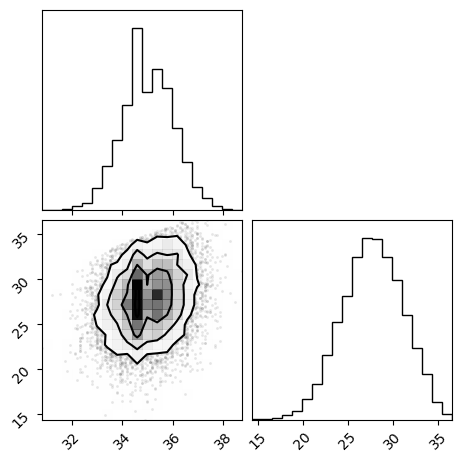

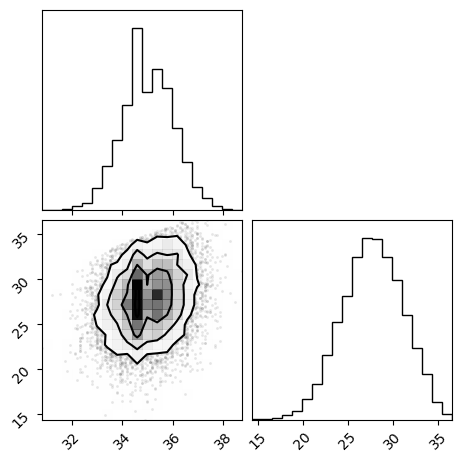

In [19]:
corner.corner(np.array([m1_samples, m2_samples]).T)

In [20]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(samples)

In [21]:
kde_samp = kde.resample(50000)

In [22]:
samp3 = np.array([m1_samples, m2_samples])

In [23]:
logp1 = kde.logpdf(samp3)
jnp.sum(-jnp.log(10000) + jnp.nan_to_num(logsumexp(logp1,axis=-1)))

Array(-4.407161, dtype=float32)

In [24]:
m1, q = m1_q_samples(10000)

samples1 = np.array([m1, q])

pm1: [0. 0. 0. ... 0. 0. 0.]
pq: [0. 0. 0. ... 0. 0. 0.]


In [25]:
logp1 = kde.logpdf(samples1)
jnp.sum(-jnp.log(10000) + jnp.nan_to_num(logsumexp(logp1,axis=-1)))

Array(-3.796801, dtype=float32)

In [26]:
samples2 = np.sort(samples1, axis=1)

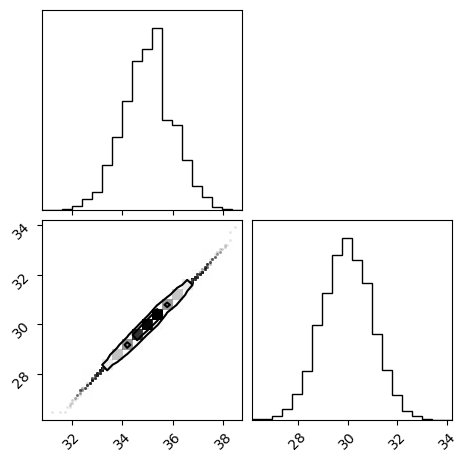

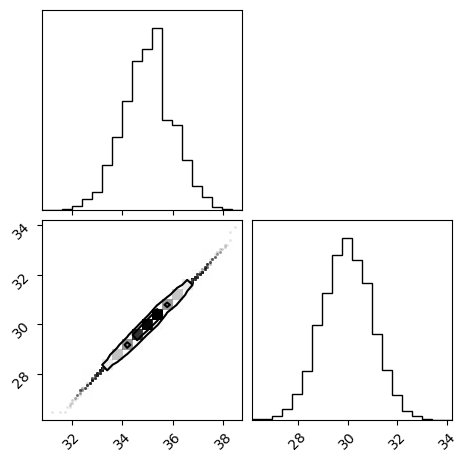

In [27]:
corner.corner(samples2.T)

# Two "events"

In [28]:
cov = [[5, 0], [0, 5]]
mean = [40, 38]
nEvents = 100

injections = np.random.multivariate_normal(mean, cov, nEvents)
inj_sorted = np.sort(injections, axis=1)
m2, m1 = inj_sorted[:, 0], inj_sorted[:, 1]

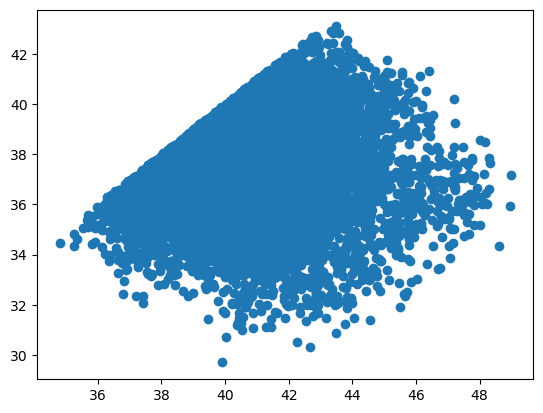

In [29]:
m1s = []
m2s = []
for i in range(nEvents):
    mean = [m1[i], m2[i]]
    cov = [[1, 0], [0, 1]]  
    temp_samp = np.random.multivariate_normal(mean, cov, 100)
    inj_sorted = np.sort(temp_samp, axis=1)
    m1s.append(inj_sorted[:, 1])
    m2s.append(inj_sorted[:, 0])



plt.scatter(m1s, m2s)

In [30]:
m1s = np.concatenate(m1s)
m2s = np.concatenate(m2s)

samp1 = np.array([m1s, m2s])

In [31]:
samp1.shape

(2, 10000)

In [32]:
m1_col = jnp.concatenate([samples[0], samp1[0]])
m2_col = jnp.concatenate([samples[1], samp1[1]])
samp_col = jnp.column_stack([m1_col, m2_col])

In [33]:
logp = log_joint_pdf(samp_col[:, 0], samp_col[:, 1], mu0, sig0, mu1, sig1)
jnp.sum(-jnp.log(20000) + jnp.nan_to_num(logsumexp(logp,axis=-1)))

Array(-4.456301, dtype=float32)

In [34]:
kdes = []
n = 2
nsamp = 10000

for i in range(n):
    temp_samp = np.array([samp_col[nsamp*i:nsamp*(i+1), 0], samp_col[nsamp*i:nsamp*(i+1), 1]])
    kdes.append(gaussian_kde(temp_samp))

In [35]:
m1, m2 = m1_q_samples(10000, mu0=35, sig0=1, mu1=30, sig1=1)

pm1: [0. 0. 0. ... 0. 0. 0.]
pq: [0. 0. 0. ... 0. 0. 0.]


In [36]:
samp3 = np.array([m1, m2])

In [37]:
pop_samples = np.array([m1, m2])

templist = []

logp1 = 0
for i in range(len(kdes)):
    if i==n:
        break
    temp = kdes[i].logpdf(pop_samples)
    templist.append(temp)
    # print(temp)
    logp1 += temp
    
        
# temp = kdes[0].logpdf(pop_samples)
# print(temp)
# logp1 += temp

templist = jnp.concatenate(templist)

ll1 = jnp.sum(-jnp.log(20000) + jnp.nan_to_num(logsumexp(templist,axis=-1)))
print(ll1)

-4.4898987


## 3 events

In [38]:
cov = [[5, 0], [0, 5]]
mean = [45, 20]
nEvents = 100

injections = np.random.multivariate_normal(mean, cov, nEvents)
inj_sorted = np.sort(injections, axis=1)
m2, m1 = inj_sorted[:, 0], inj_sorted[:, 1]

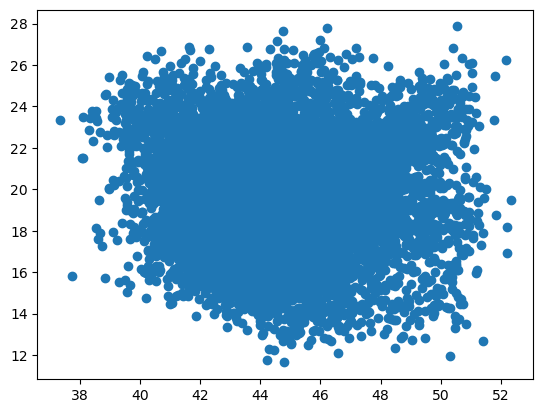

In [39]:
m1s = []
m2s = []
for i in range(nEvents):
    mean = [m1[i], m2[i]]
    cov = [[1, 0], [0, 1]]  
    temp_samp = np.random.multivariate_normal(mean, cov, 100)
    inj_sorted = np.sort(temp_samp, axis=1)
    m1s.append(inj_sorted[:, 1])
    m2s.append(inj_sorted[:, 0])



plt.scatter(m1s, m2s)

In [40]:
m1s = np.concatenate(m1s)
m2s = np.concatenate(m2s)

samp4 = np.array([m1s, m2s])

In [41]:
samp_col[:, 1]

Array([29.873058, 30.39799 , 29.249973, ..., 35.78367 , 36.270737,
       35.633972], dtype=float32)

In [42]:
samp_col[0]

Array([36.09222 , 29.873058], dtype=float32)

In [43]:
m1_col = jnp.concatenate([samp_col[:, 0], samp4[0]])
m2_col = jnp.concatenate([samp_col[:, 1], samp4[1]])
samp_col = jnp.column_stack([m1_col, m2_col])

In [44]:
logp = log_joint_pdf(samp_col[:, 0], samp_col[:, 1], mu0, sig0, mu1, sig1)
jnp.sum(-jnp.log(30000) + jnp.nan_to_num(logsumexp(logp,axis=-1)))

Array(-4.8617663, dtype=float32)

In [45]:
for i in range(n):
    print(i)

0
1


In [46]:
kdes = []
n = 3
nsamp = 10000

for i in range(n):
    temp_samp = np.array([samp_col[nsamp*i:nsamp*(i+1), 0], samp_col[nsamp*i:nsamp*(i+1), 1]])
    kdes.append(gaussian_kde(temp_samp))
    
m1, m2 = m1_q_samples(10000)

pop_samples = np.array([m1, m2])

templist = []

logp1 = 0
for i in range(len(kdes)):
    if i==n:
        break
    temp = kdes[i].logpdf(pop_samples)
    templist.append(temp)
    print(temp)
    logp1 += temp
    
        
# temp = kdes[0].logpdf(pop_samples)
# print(temp)
# logp1 += temp

templist = jnp.concatenate(templist)

ll1 = jnp.sum(-jnp.log(30000) + jnp.nan_to_num(logsumexp(templist,axis=-1)))
print(ll1)

pm1: [0. 0. 0. ... 0. 0. 0.]
pq: [0. 0. 0. ... 0. 0. 0.]
[-3.63581063 -3.68886429 -3.68412325 ... -3.67327262 -3.684506
 -3.68852318]
[-38.15725807 -32.85125887 -25.9626631  ... -27.03556953 -44.22881488
 -46.33788272]
[-65.80783404 -59.96033948 -72.50113735 ... -91.15663898 -72.66617994
 -68.59811302]
-4.895364


# Three parameters test

In [47]:
cov = [[5, 0, 0], [0, 3, 0], [0, 0, 4]]
mean = [40, 38, 20]
nEvents = 100

injections = np.random.multivariate_normal(mean, cov, nEvents)
inj_sorted = np.sort(injections, axis=1)
m3, m2, m1 = inj_sorted[:, 0], inj_sorted[:, 1], inj_sorted[:, 2]

In [48]:
m1s = []
m2s = []
m3s = []
for i in range(nEvents):
    mean = [m1[i], m2[i], m3[i]]
    cov = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]  
    temp_samp = np.random.multivariate_normal(mean, cov, 100)
    inj_sorted = np.sort(temp_samp, axis=1)
    m1s.append(inj_sorted[:, 1])
    m2s.append(inj_sorted[:, 0])
    m3s.append(inj_sorted[:, 2])



# plt.scatter(m1s, m2s)

In [49]:
m1s = np.concatenate(m1s)
m2s = np.concatenate(m2s)
m3s = np.concatenate(m3s)

samp1 = np.array([m1s, m2s, m3s])

In [50]:
mass = np.linspace(1, 100, 1000)
mass_ratio = np.linspace(1, 100, 1000)
redshift = jnp.linspace(1, 100, 1000)

def pm1_peak(m1,mu,sigma):
    pm1 =  jnp.exp(-(mass - mu)**2 / (2 * sigma ** 2))
    pm1 = pm1/jnp.trapezoid(pm1,mass)
    return jnp.interp(m1,mass,pm1)

def pdL_peak(dL, mu, sigma):
    pdL = jnp.exp(-(dL - mu)**2 / (2 * sigma ** 2))
    pdL = pdL/jnp.trapezoid(pdL, redshift)
    return jnp.interp(dL, redshift, pdL)

def joint_pdf(m1, q, z, mu0, sig0, mu1, sig1, mu2, sig2):
    pm1 = pm1_peak(m1, mu0, sig0)
    pq = pm1_peak(q, mu1, sig1)
    pz = pm1_peak(z, mu2, sig2)

    return pm1 * pq * pz

def log_joint_pdf(m1, q, z, mu0, sig0, mu1, sig1, mu2, sig2):
    pm1 = jnp.log(pm1_peak(m1, mu0, sig0))
    pq = jnp.log(pm1_peak(q, mu1, sig1))
    pz = jnp.log(pm1_peak(z, mu2, sig2))
    print(pm1, pq, pz)
    return pm1 + pq + pz

In [73]:
m1s

array([36.20329371, 39.68069813, 39.34718073, ..., 36.72330472,
       35.49049127, 33.51982275], shape=(10000,))

In [166]:
samp1[2]

array([40.98181986, 40.53139792, 41.95767583, ..., 39.27212426,
       42.19035393, 41.71949874], shape=(10000,))

In [51]:
mu0 = 40
mu1 = 38
mu2 = 20

sig0 = 1
sig1 = 1
sig2 = 1



logp = log_joint_pdf(samp1[2], samp1[0], samp1[1], mu0, sig0, mu1, sig1, mu2, sig2)
jnp.sum(-jnp.log(10000) + jnp.nan_to_num(logsumexp(logp,axis=-1)))

[ -2.900486   -1.0433187  -0.9371147 ...  -5.852603   -8.372583
 -12.065857 ] [ -2.5310566  -2.3293524  -1.8262321 ...  -1.7331462  -4.0667076
 -10.941579 ] [-16.546309  -11.124004  -14.57304   ...  -1.4228495  -1.0212759
  -1.0666916]


Array(-5.5027876, dtype=float32)

In [55]:
samp2, _ = metro_mc(nsamp=10000)

In [59]:
samp2.shape

(10000, 3)

In [61]:
samp1[0]

array([36.20329371, 39.68069813, 39.34718073, ..., 36.72330472,
       35.49049127, 33.51982275], shape=(10000,))

In [63]:
samp1[1]

array([25.59403236, 24.52243089, 25.2318764 , ..., 18.9960721 ,
       20.45072188, 20.54261497], shape=(10000,))

In [75]:
m1s

array([36.20329371, 39.68069813, 39.34718073, ..., 36.72330472,
       35.49049127, 33.51982275], shape=(10000,))

In [76]:
samp3 = np.array([m3s, m1s, m2s])

In [78]:
samp3.shape, samp2.shape

((3, 10000), (10000, 3))

In [79]:
kde = gaussian_kde(samp3)
# samp2 = kde.resample(10000)
logpdf = kde.logpdf(samp2.T)
jnp.sum(-jnp.log(10000) + jnp.nan_to_num(logsumexp(logpdf,)))


Array(-5.5507627, dtype=float32)

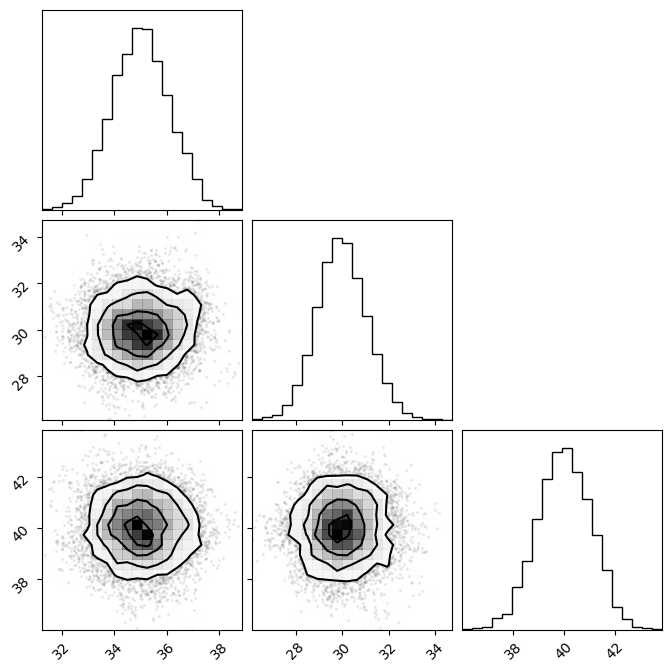

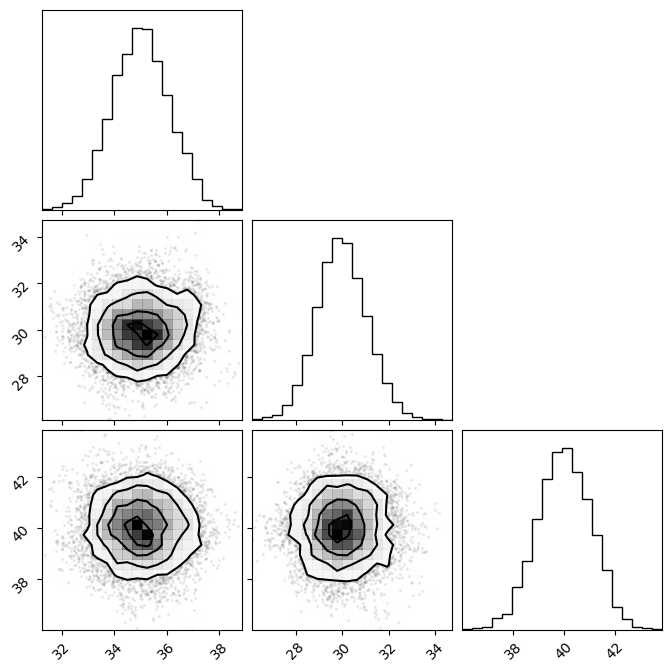

In [53]:
corner.corner(samp2.T)

# More realistic, adding redshift

In [161]:
cov = [[3, 0, 0], [0, 3, 0], [0, 0, 1000]]
mean = [35, 30, 4000]
nsamp = 1000

injections = np.random.multivariate_normal(mean, cov, nEvents)
inj_sorted = np.sort(injections, axis=1)
m2, m1, dL = inj_sorted[:, 0], inj_sorted[:, 1], inj_sorted[:, 2]

In [162]:
m1s = []
m2s = []
dLs = []
for i in range(nEvents):
    mean = [m1[i], m2[i], dL[i]]
    cov = [[1, 0, 0], [0, 1, 0], [0, 0, 100]]  
    temp_samp = np.random.multivariate_normal(mean, cov, 100)
    inj_sorted = np.sort(temp_samp, axis=1)
    m1s.append(inj_sorted[:, 1])
    m2s.append(inj_sorted[:, 0])
    dLs.append(inj_sorted[:, 2])

In [163]:
m1s = np.concatenate(m1s)
m2s = np.concatenate(m2s)
dLs = np.concatenate(dLs)



In [164]:
from astropy.cosmology import Planck15, FlatLambdaCDM
import astropy.constants as constants
import astropy.units as u
from jax import jit
from tqdm import tqdm
from jaxinterp2d import interp2d, CartesianGrid

H0Planck = Planck15.H0.value
Om0Planck = Planck15.Om0

zMax = 5
zgrid = jnp.expm1(jnp.linspace(jnp.log(1), jnp.log(zMax+1), 500))
Om0grid = jnp.linspace(Om0Planck-0.1,Om0Planck+0.1,50)

cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Planck15.Om0)
speed_of_light = constants.c.to('km/s').value

rs = []
for Om0 in tqdm(Om0grid):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0)
    rs.append(cosmo.comoving_distance(zgrid).to(u.Mpc).value)

rs = jnp.asarray(rs)
rs = rs.reshape(len(Om0grid),len(zgrid))

@jit
def E(z,Om0=Om0Planck):
    return jnp.sqrt(Om0*(1+z)**3 + (1.0-Om0))

@jit
def r_of_z(z,H0,Om0=Om0Planck):
    return interp2d(Om0,z,Om0grid,zgrid,rs)*(H0Planck/H0)

@jit
def dL_of_z(z,H0=H0Planck,Om0=Om0Planck):
    return (1+z)*r_of_z(z,H0,Om0)

@jit
def z_of_dL(dL,H0=H0Planck,Om0=Om0Planck):
    return jnp.interp(dL,dL_of_z(zgrid,H0,Om0),zgrid)

@jit
def dV_of_z(z,H0,Om0=Om0Planck):
    return speed_of_light*r_of_z(z,H0,Om0)**2/(H0*E(z,Om0))

@jit
def ddL_of_z(z,dL,H0,Om0=Om0Planck):
    return dL/(1+z) + speed_of_light*(1+z)/(H0*E(z,Om0))

100%|██████████| 50/50 [00:00<00:00, 233.41it/s]


In [165]:
zs = z_of_dL(dLs)

In [190]:
samp1 = np.array([m1s, m2s, zs]) # array with redshift

In [ ]:
redshift = jnp.linspace(0.01, 2, 1000)

def pz_peak(m1,mu,sigma):
    pm1 =  jnp.exp(-(redshift - mu)**2 / (2 * sigma ** 2))
    pm1 = pm1/jnp.trapezoid(pm1,redshift)
    return jnp.interp(m1,redshift,pm1)

def joint_pdf(m1, q, z, mu0, sig0, mu1, sig1, mu2, sig2):
    pm1 = pm1_peak(m1, mu0, sig0)
    pq = pm1_peak(q, mu1, sig1)
    pz = pz_peak(z, mu2, sig2)
    
    return pm1 * pq * pz

def log_joint_pdf(m1, q, z, mu0, sig0, mu1, sig1, mu2, sig2):
    pm1 = jnp.log(pm1_peak(m1, mu0, sig0))
    pq = jnp.log(pm1_peak(q, mu1, sig1))
    pz = jnp.log(pz_peak(z, mu2, sig2))
    
    # test = pz_peak(z, mu2, sig2)
    
    # jax.debug.print('{}', test[0])
    # jax.debug.print('{}', pm1)
    # print(z, mu2, sig2)
    
    return pm1 + pq + pz

In [168]:
samp1[1]

array([29.26913074, 30.73895065, 31.5103065 , ..., 30.54778715,
       29.18052145, 31.23270202], shape=(10000,))

In [186]:
mu0 = 35
sig0 = 1
mu1 = 30
sig1 = 1
mu2 = 0.65
sig2 = 0.5

logp = log_joint_pdf(samp1[0], samp1[1], samp1[2], mu0, sig0, mu1, sig1, mu2, sig2)
logp += - jnp.log(ddL_of_z(samp1[2],dLs,H0Planck,Om0Planck))

print('log likelihood is: ', jnp.sum(-jnp.log(10000) + jnp.nan_to_num(logsumexp(logp,axis=-1))))

log likelihood is:  -12.553601


## Method 2

In [170]:
def metro_mc(nsamp=10000,
             mu0=35, sig0=1, mu1=30, sig1=1, mu2=0.65, sig2=0.01,
             m_min=5.0, m_max=100.0,
             q_min=5.0, q_max=100.0,
             z_min=0.0, z_max=2.0,
             proposal_std_m=3.0, proposal_std_q=3.0, proposal_std_z=0.03):
    """
    Simple Metropolis-Hastings sampling of (m1, q) within [m_min, m_max] × [q_min, q_max].
    - compute_pdf(m1, q) should return non-negative density (unnormalized).
    """
    samples = np.zeros((nsamp, 3))
    p_vals = np.zeros(nsamp)

    # Example compute_pdf using some user-defined pm1_peak and fq functions.
    # These must be defined elsewhere and accept numpy floats (or arrays).
    def compute_pdf(m1, q, z):
        # Check bounds; return zero density outside
        if (m1 < m_min) or (m1 > m_max) or (q < q_min) or (q > q_max) or (z < z_min) or (z > z_max): 
            return 0.0
        # User’s functions; ensure they accept/return numpy floats
        pm1 = pm1_peak(m1, mu0, sig0)    # e.g. Gaussian in m1
        pq = pm1_peak(q, mu1, sig1)               # e.g. power-law in q
        pz = pz_peak(z, mu2, sig2)
        # If these return arrays, ensure you index appropriately.
        # Here assume they return scalar floats when inputs are floats.
        return pm1 * pq * pz    

    # Initialize first sample somewhere inside the domain.
    # Could choose (mu, midpoint of q-range) or draw random uniform:
    samples[0, 0] = np.clip(mu0, m_min, m_max)  # or np.random.uniform(m_min, m_max)
    samples[0, 1] = np.clip(mu1, q_min, q_max)
    samples[0, 2] = np.clip(mu2, z_min, z_max)
    # samples[0, 1] = np.clip((q_min + q_max) / 2, q_min, q_max)
    # samples[0, 2] = np.clip((z_min + z_max) / 2, z_min, z_max)
    p_vals[0] = compute_pdf(samples[0,0], samples[0,1], samples[0,2])

    for i in range(1, nsamp):
        current_m, current_q, current_z = samples[i-1]
        # Propose new point via Gaussian steps:
        prop_m = current_m + np.random.normal(scale=proposal_std_m)
        prop_q = current_q + np.random.normal(scale=proposal_std_q)
        prop_z = current_z + np.random.normal(scale=proposal_std_z)
        # Boundary check: if out of allowed range, reject immediately
        if (prop_m < m_min) or (prop_m > m_max) or (prop_q < q_min) or (prop_q > q_max) or (prop_z < z_min) or (prop_z > z_max):
            # reject: keep previous
            samples[i] = samples[i-1]
            p_vals[i] = p_vals[i-1]
            continue

        # Otherwise compute density at proposal
        p_prop = compute_pdf(prop_m, prop_q, prop_z)
        p_curr = p_vals[i-1]

        # If current density is zero (should not happen if initialization in support), you might treat carefully:
        if p_curr <= 0:
            # To avoid division by zero, you could automatically accept if p_prop>0,
            # or simply set accept=False; depends on context. Here, if current has zero density but proposal>0,
            # you might accept to move into support:
            accept = (p_prop > 0)
        else:
            # Standard Metropolis acceptance:
            if p_prop >= p_curr:
                accept = True
            else:
                accept = np.random.rand() < (p_prop / p_curr)

        if accept:
            samples[i, 0] = prop_m
            samples[i, 1] = prop_q
            samples[i, 2] = prop_z
            p_vals[i] = p_prop
        else:
            samples[i] = samples[i-1]
            p_vals[i] = p_curr

    return samples, p_vals

In [191]:
samp2, _ = metro_mc(nsamp=50000, mu0=35, sig0=1, mu1=30, sig1=1, mu2=0.65, sig2=0.5) # samples drawn from model


In [172]:
samp2[:, 2]

array([0.65      , 0.65      , 0.65      , ..., 0.86940409, 0.86940409,
       0.86940409], shape=(50000,))

In [173]:
dll = dL_of_z(samp2[:, 2],H0Planck,Om0Planck)

In [174]:
jnp.log(ddL_of_z(samp2[:, 2],dll,H0Planck,Om0Planck))

Array([8.922641, 8.922641, 8.922641, ..., 8.998916, 8.998916, 8.998916],      dtype=float32)

In [188]:
samp0 = jnp.array([m1s, m2s, dLs]) # Original posterior
samp2_ = jnp.array([samp2[:, 0], samp2[:, 1], dll]) # samples drawn from model and transformed to dL

In [189]:
kde = gaussian_kde(samp0)
logpdf = kde.logpdf(samp2_)
logpdf += jnp.log(ddL_of_z(samp2[:, 2],dll,H0Planck,Om0Planck))

print('log likelihood is: ', jnp.sum(-jnp.log(50000) + jnp.nan_to_num(logsumexp(logpdf, axis=-1))))


log likelihood is:  -3.9101548
